In [1]:
!python --version


Python 3.11.4


In [2]:
import math
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datetime
import time
import random
from PIL import Image
import pickle
import joblib
import re

from sklearn import preprocessing
import tensorflow as tf
from keras.layers import Input,Dense,LSTM,Flatten,Dropout,concatenate,Conv1D,MaxPooling2D,Activation
from keras.layers import BatchNormalization
from keras.layers import Embedding
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# import keras_tuner
from tensorflow import keras
import tensorflow_hub as hub
import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Convert .josn file to .csv
mscoco_train2014_que = json.load(open(f'v2_OpenEnded_mscoco_train2014_questions.json','r'))
mscoco_train2014_ans = json.load(open(f'v2_mscoco_train2014_annotations.json','r'))

mscoco_train2014_que_df = pd.DataFrame(mscoco_train2014_que['questions'])
mscoco_train2014_ans_df = pd.DataFrame(mscoco_train2014_ans['annotations'])

mscoco_train2014 = pd.merge(mscoco_train2014_que_df, mscoco_train2014_ans_df, on=["image_id", "question_id"])

cols = ['image_id','question_id','question','question_type','multiple_choice_answer','answers','answer_type']
mscoco_train2014 = mscoco_train2014[cols]


#convert image_id to image_path
def image_id_to_path(subset,image_id):
    imdir='%s/COCO_%s_%012d.jpg'
    image_path = imdir%(subset, subset, image_id)
    return image_path

subset = 'train2014'
image_path = []
for i in (range(len(mscoco_train2014))):
    image_path.append(image_id_to_path(subset,mscoco_train2014['image_id'][i]))
mscoco_train2014['image_id'] = image_path


# create a list of multiple answers of an question
answers_list = []
for i in (range(len(mscoco_train2014))):
    ans_list = []
    for dic in (mscoco_train2014['answers'][i]):
        ans_list.append(dic['answer'])
    answers_list.append(ans_list)
mscoco_train2014['answers'] = answers_list

# save dataframe to .csv
mscoco_train2014.to_csv("F:/major project/Functionalities/Visual Question Answering/VQA/data/mscoco_train2014.csv",index=False)

mscoco_train2014 = pd.read_csv("F:/major project/Functionalities/Visual Question Answering/VQA/data/mscoco_train2014.csv")
print('Number of Question & Answer in MSCOCO Train Dataset:',len(mscoco_train2014))
mscoco_train2014.head(5)

Number of Question & Answer in MSCOCO Train Dataset: 443757


,image_id,question_id,question,question_type,multiple_choice_answer,answers,answer_type
0,train2014/COCO_train2014_000000458752.jpg,458752000,What is this photo taken looking through?,what is this,net,"['net', 'net', 'net', 'netting', 'net', 'net',...",other
1,train2014/COCO_train2014_000000458752.jpg,458752001,What position is this man playing?,what,pitcher,"['pitcher', 'catcher', 'pitcher', 'pitcher', '...",other
2,train2014/COCO_train2014_000000458752.jpg,458752002,What color is the players shirt?,what color is the,orange,"['orange', 'orange', 'orange', 'orange', 'oran...",other
3,train2014/COCO_train2014_000000458752.jpg,458752003,Is this man a professional baseball player?,is this,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes...",yes/no
4,train2014/COCO_train2014_000000262146.jpg,262146000,What color is the snow?,what color is the,white,"['white', 'white', 'white', 'white', 'white', ...",other


In [4]:
mscoco_path = r"F:/major project/Functionalities/Visual Question Answering/"
image_path = list(mscoco_train2014['image_id'])
question = list(mscoco_train2014['question'])
answer = list(mscoco_train2014['multiple_choice_answer'])

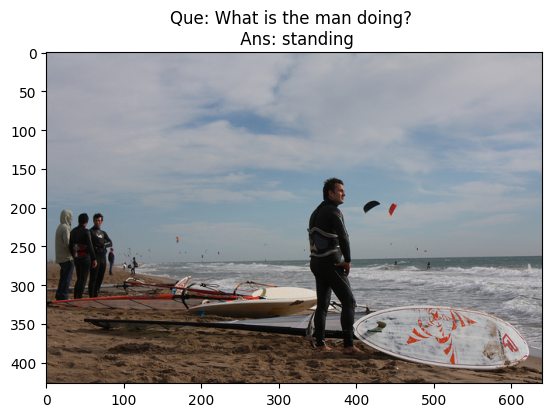

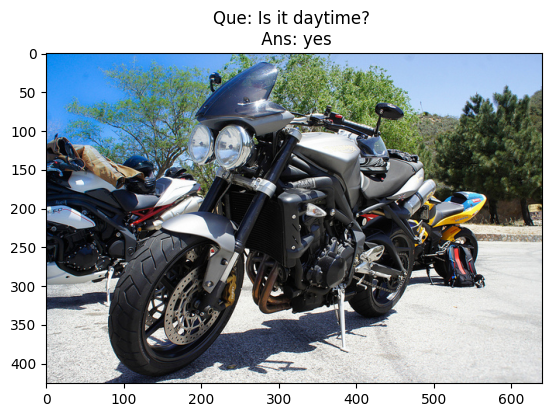

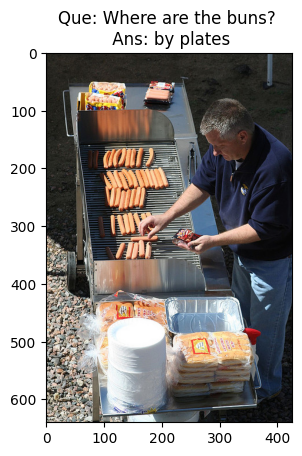

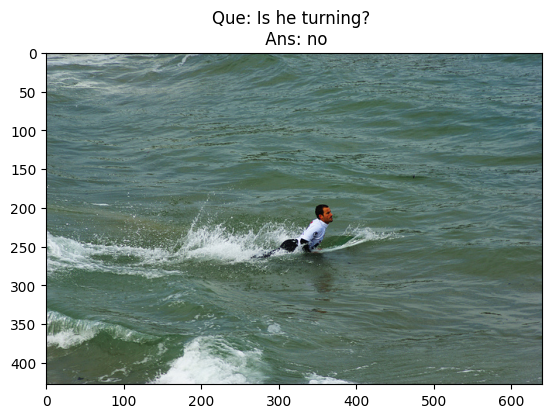

In [5]:
# Plot sample images, questions and answers
temp = random.sample(range(0, 1000), 4)
for a,i in enumerate(temp):
    image = plt.imread(mscoco_path+image_path[i])
    plt.figure()
    plt.title(f'Que: {question[i]} \n Ans: {answer[i]}')
    plt.imshow(image)

In [6]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    
    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)
    
    phrase = re.sub(r"he\’s", "he is", phrase)
    phrase = re.sub(r"she\’s", "she is", phrase)
    phrase = re.sub(r"it\’s", "it is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase


def text_preprocess(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9. ]+', '', text) # remove all punctuation, except A-Za-z0-9 
    text = re.sub(' +', ' ', text) # remove extra space
    return text

def text_preprocess_ans(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9.! ]+', '', text) # remove all punctuation, except A-Za-z0-9 
    text = re.sub(' +', ' ', text) # remove extra space
    return text

In [7]:
# Question and Answer text preprocessing
mscoco_train2014["question_preprocessed"] = mscoco_train2014["question"].map(lambda x: text_preprocess(x))
mscoco_train2014["answer_preprocessed"] = mscoco_train2014["multiple_choice_answer"].map(lambda x: text_preprocess_ans(x))

In [8]:
# Sample Questions and Answers Befor and after text preprocessing
temp = random.sample(range(0, len(mscoco_train2014)), 4)
for i in temp:
    print(f'Que: {mscoco_train2014["question"][i]}\nAns: {mscoco_train2014["multiple_choice_answer"][i]}')
print('-'*50)
for i in temp:
    print(f'Que: {mscoco_train2014["question_preprocessed"][i]}\nAns: {mscoco_train2014["answer_preprocessed"][i]}')

Que: Is the bowl white?
Ans: yes
Que: Is there a shower curtain?
Ans: no
Que: Who is holding the baby?
Ans: man
Que: What is in the vase?
Ans: glass flowers
--------------------------------------------------
Que: is the bowl white
Ans: yes
Que: is there a shower curtain
Ans: no
Que: who is holding the baby
Ans: man
Que: what is in the vase
Ans: glass flowers


In [9]:
mscoco_train2014 = mscoco_train2014.drop(['question', 'multiple_choice_answer'], axis=1)

cols = ['image_id','question_id','question_preprocessed','question_type','answer_preprocessed','answers','answer_type']
mscoco_train2014 = mscoco_train2014[cols]

# save dataframe to .csv
mscoco_train2014.to_csv("F:/major project/Functionalities/Visual Question Answering/VQA/data/mscoco_train2014_preprocessed.csv",index=False)

mscoco_train2014 = pd.read_csv("F:/major project/Functionalities/Visual Question Answering/VQA/data/mscoco_train2014_preprocessed.csv")
print('Number of Question & Answer in MSCOCO Train Dataset:',len(mscoco_train2014))
mscoco_train2014.head(2)

Number of Question & Answer in MSCOCO Train Dataset: 443757


,image_id,question_id,question_preprocessed,question_type,answer_preprocessed,answers,answer_type
0,train2014/COCO_train2014_000000458752.jpg,458752000,what is this photo taken looking through,what is this,net,"['net', 'net', 'net', 'netting', 'net', 'net',...",other
1,train2014/COCO_train2014_000000458752.jpg,458752001,what position is this man playing,what,pitcher,"['pitcher', 'catcher', 'pitcher', 'pitcher', '...",other


In [10]:
image_path = list(mscoco_train2014['image_id'])
question_preprocessed = list(mscoco_train2014['question_preprocessed'])
answer_preprocessed = list(mscoco_train2014['answer_preprocessed'])
question_type = list(mscoco_train2014['question_type'])
answer_type = list(mscoco_train2014['answer_type'])

In [11]:
preprocessed_data_df= mscoco_train2014

In [12]:
preprocessed_data_df.head()

,image_id,question_id,question_preprocessed,question_type,answer_preprocessed,answers,answer_type
0,train2014/COCO_train2014_000000458752.jpg,458752000,what is this photo taken looking through,what is this,net,"['net', 'net', 'net', 'netting', 'net', 'net',...",other
1,train2014/COCO_train2014_000000458752.jpg,458752001,what position is this man playing,what,pitcher,"['pitcher', 'catcher', 'pitcher', 'pitcher', '...",other
2,train2014/COCO_train2014_000000458752.jpg,458752002,what color is the players shirt,what color is the,orange,"['orange', 'orange', 'orange', 'orange', 'oran...",other
3,train2014/COCO_train2014_000000458752.jpg,458752003,is this man a professional baseball player,is this,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes...",yes/no
4,train2014/COCO_train2014_000000262146.jpg,262146000,what color is the snow,what color is the,white,"['white', 'white', 'white', 'white', 'white', ...",other


In [13]:
print("Unique number of answers of MSCOCO Dataset:",len(set(preprocessed_data_df['answer_preprocessed'])))

Unique number of answers of MSCOCO Dataset: 22350


In [14]:
# print("Unique set of answers of MSCOCO Dataset:",set(preprocessed_data_df['answer_preprocessed']))

In [15]:
# create dataframe of unique answers and its counts in decending order of answer_count
answer_preprocessed = list(preprocessed_data_df['answer_preprocessed'])
count = {}
for i in answer_preprocessed:
    count[i] = count.get(i, 0) + 1
    
answer_df = pd.DataFrame(list(count.items()),columns=["answer","answer_count"])
answer_df["answer%"] = answer_df["answer_count"]/len(answer_preprocessed)*100  
answer_df = answer_df.sort_values(by='answer_count',ascending=False)

In [16]:
answer_df

,answer,answer_count,answer%
3,yes,84978,19.149670
11,no,82516,18.594862
15,1,12541,2.826096
20,2,12215,2.752633
4,white,8916,2.009208
...,...,...,...
11571,blueprint,1,0.000225
11573,1890,1,0.000225
11574,merry christmas italian tomato,1,0.000225
11577,749,1,0.000225


In [17]:
# Consider top 1000 answers as class label
top_1000_answers = list(answer_df['answer'])[:1000]

data_df = pd.DataFrame()
for i in (range(len(top_1000_answers))):
  data_df = pd.concat([data_df, preprocessed_data_df[preprocessed_data_df.answer_preprocessed == top_1000_answers[i]]])

print(f"Top 1000 answers coverd {round(len(data_df)/443757*100,2)}% of datapoints")
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(top_1000_answers)
pickle.dump((labelencoder),open('F:/major project/Functionalities/Visual Question Answering/VQA/models/labelencoder.pkl','wb'))
labelencoder = pickle.load(open('F:/major project/Functionalities/Visual Question Answering/VQA/models/labelencoder.pkl', 'rb'))


data_df['class_label'] = labelencoder.transform(list(data_df['answer_preprocessed']))
print("Number of Class Labels:",len(labelencoder.classes_))

data_df = data_df.drop(['question_id', 'question_type', 'answer_type'], axis=1)
print("Number of datapoints of final dataset:",len(data_df))
data_df.to_csv("F:/major project/Functionalities/Visual Question Answering/VQA/data/mscoco_train2014_preprocessed_k1000.csv",index=False)
data_df.head(3)

Top 1000 answers coverd 87.5% of datapoints
Number of Class Labels: 1000
Number of datapoints of final dataset: 388272


,image_id,question_preprocessed,answer_preprocessed,answers,class_label
3,train2014/COCO_train2014_000000458752.jpg,is this man a professional baseball player,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes...",995
8,train2014/COCO_train2014_000000524291.jpg,is the dog waiting,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye...",995
10,train2014/COCO_train2014_000000393221.jpg,is the sky blue,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye...",995


In [18]:
data_df.to_csv("F:/major project/Functionalities/Visual Question Answering/VQA/data/mscoco_train2014_preprocessed_k1000.csv",index=False)

In [19]:
X = data_df[['image_id','question_preprocessed','answers']]
y = data_df['class_label']
print('X.shape:',X.shape)
print('y.shape:',y.shape)

data_df.groupby(by='class_label').count()

X.shape: (388272, 3)
y.shape: (388272,)


,image_id,question_preprocessed,answer_preprocessed,answers
class_label,,,,
0,4977,4977,4977,4977
1,12541,12541,12541,12541
2,986,986,986,986
3,28,28,28,28
4,41,41,41,41
...,...,...,...,...
995,84978,84978,84978,84978
996,98,98,98,98
997,342,342,342,342


In [20]:
data_df_k1000 = pd.read_csv("F:/major project/Functionalities/Visual Question Answering/VQA/data/mscoco_train2014_preprocessed_k1000.csv")
data_df_k1000.head(3)

,image_id,question_preprocessed,answer_preprocessed,answers,class_label
0,train2014/COCO_train2014_000000458752.jpg,is this man a professional baseball player,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes...",995
1,train2014/COCO_train2014_000000524291.jpg,is the dog waiting,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye...",995
2,train2014/COCO_train2014_000000393221.jpg,is the sky blue,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye...",995


In [21]:
# to get 50k datapoints from dataset with same %count as in dataset

X = data_df_k1000[['image_id','question_preprocessed','answer_preprocessed','answers','class_label']]
y = data_df_k1000['class_label']
print('X.shape:',X.shape)
print('y.shape:',y.shape)

X_, X_50k, y_, y_50k = train_test_split(X, y, test_size=0.1314, stratify=y, random_state=42)
print('X_50k.shape:',X_50k.shape)
print('y_50k.shape:',y_50k.shape)

# X_50k.to_csv("/content/drive/MyDrive/Applied AI/CS2/Data/mscoco_train2014_preprocessed_k1000_50k.csv",index=False)

X.shape: (388272, 5)
y.shape: (388272,)
X_50k.shape: (51019, 5)
y_50k.shape: (51019,)


In [22]:
X_50k.to_csv("F:/major project/Functionalities/Visual Question Answering/VQA/data/mscoco_train2014_preprocessed_k1000_50k.csv",index=False)

In [23]:
data_df_50k = pd.read_csv("F:/major project/Functionalities/Visual Question Answering/VQA/data/mscoco_train2014_preprocessed_k1000_50k.csv")

X = data_df_50k[['image_id','question_preprocessed', 'answers']]
y = data_df_50k['class_label']
print('X.shape:',X.shape)
print('y.shape:',y.shape)

X.shape: (51019, 3)
y.shape: (51019,)


In [24]:
# # perform train validation & test split on the dataset
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42) 
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.10, stratify=y_train, random_state=42) 

# pickle.dump((X_train,y_train),open('F:/major project/Functionalities/Visual Question Answering/VQA/models/train_50k_0711.pkl','wb'))
# pickle.dump((X_val,y_val),open('F:/major project/Functionalities/Visual Question Answering/VQA/models/val_50k_0711.pkl','wb'))
# pickle.dump((X_test,y_test),open('F:/major project/Functionalities/Visual Question Answering/VQA/models/test_50k_0711.pkl','wb'))

In [25]:
X_train,y_train = pickle.load(open('F:/major project/Functionalities/Visual Question Answering/VQA/models/train_50k_0711.pkl', 'rb'))
X_val,y_val = pickle.load(open('F:/major project/Functionalities/Visual Question Answering/VQA/models/val_50k_0711.pkl', 'rb'))
X_test,y_test = pickle.load(open('F:/major project/Functionalities/Visual Question Answering/VQA/models/test_50k_0711.pkl', 'rb'))

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# Convert a class vector y_train and y_test to binary class matrix
Y_train = to_categorical(y_train, 1000) 
Y_val = to_categorical(y_val, 1000)
Y_test = to_categorical(y_test, 1000)

(41325, 3) (41325,)
(5102, 3) (5102,)
(4592, 3) (4592,)


In [26]:
X_train

,image_id,question_preprocessed,answers
28233,train2014/COCO_train2014_000000249529.jpg,are there any mountains around,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye..."
16447,train2014/COCO_train2014_000000371360.jpg,is the womans shoulder exposed,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye..."
10178,train2014/COCO_train2014_000000387849.jpg,is this train hauling cargo or people,"['people', 'people', 'people', 'people', 'peop..."
11896,train2014/COCO_train2014_000000019471.jpg,what is on the ground,"['snow', 'snow', 'snow', 'snow', 'snow', 'snow..."
9694,train2014/COCO_train2014_000000122182.jpg,where is the shadow,"['next to girl', 'left of woman', 'right of pe..."
...,...,...,...
7256,train2014/COCO_train2014_000000411767.jpg,does art need to eat sheep for sustenance,"['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no..."
15598,train2014/COCO_train2014_000000379193.jpg,is the person touching the cats head or tail,"['no', 'head', 'neither', 'head', 'head', 'hea..."
44546,train2014/COCO_train2014_000000105825.jpg,is anyone in the photo,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye..."
39701,train2014/COCO_train2014_000000175284.jpg,what are these people wearing,"['jackets', 'snow wear', 'jackets and snow pan..."


In [27]:
# Train Validation & Test Text vectorization
t = Tokenizer(filters='')
t.fit_on_texts(list(X_train['question_preprocessed']))
vocab_size = len(t.word_index) + 1

# pickle.dump((t),open('D:/VQA/models/tokenizer_50k.pkl','wb'))

train_sequences = t.texts_to_sequences(list(X_train['question_preprocessed']))
train_padded_docs = pad_sequences(train_sequences, maxlen=22, padding='post')

val_sequences = t.texts_to_sequences(list(X_val['question_preprocessed']))
val_padded_docs = pad_sequences(val_sequences, maxlen=22, padding='post')

test_sequences = t.texts_to_sequences(list(X_test['question_preprocessed']))
test_padded_docs = pad_sequences(test_sequences, maxlen=22, padding='post')

In [28]:
import gensim.models.word2vec as w2v

def create_custom_embeddings(data, vector_size=300, min_count=1):
  """
  Creates custom word embeddings for your data using Gensim's Word2Vec.

  Args:
    data (list): A list of sentences (lists of words) representing your data.
    vector_size (int): Dimensionality of the word vectors. Defaults to 300.
    min_count (int): Minimum frequency of a word to be included in the vocabulary. Defaults to 1.

  Returns:
    gensim.models.word2vec.Word2Vec: The trained Word2Vec model.
  """

  # Preprocess your data here (e.g., lowercase, remove punctuation)
  processed_data = preprocess_data(data)  # Replace with your preprocessing function

  # Train the Word2Vec model
  model = w2v.Word2Vec(processed_data, min_count=min_count, vector_size=vector_size)
  return model

In [29]:

def load_glove_embeddings(glove_file, word_dim=300):
  """
  Loads pre-trained GloVe embeddings from a text file.

  Args:
    glove_file (str): Path to the GloVe text file. Defaults to 'glove.6B.300d.txt'.
    word_dim (int): Dimensionality of the word vectors. Defaults to 300.

  Returns:
    dict: A dictionary mapping words to their corresponding word vectors.
    int: The dimensionality of the word vectors.
  """

  embeddings_index = {}
  f = open(glove_file, encoding='utf-8')
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
  f.close()
  return embeddings_index, word_dim

In [30]:
def preprocess_data(text_file):
  """
  Preprocesses text data from a file for Word2Vec training.

  Args:
    text_file (str): Path to the text file.

  Returns:
    list: A list of lists of words representing the preprocessed sentences.
  """

  sentences = []
  with open(text_file, 'r', encoding='utf-8') as f:
    for line in f:
      # Lowercase and remove punctuation
      line = line.lower().strip()
      words = [word for word in line.split() if word.isalpha()]  # Keep only alphabets
      if words:  # Only append sentences with at least one word
        sentences.append(words)
  return sentences



model = create_custom_embeddings('questions.txt')

In [31]:
model

In [32]:
def get_custom_encoding(word, model):
  """
  Retrieves the custom word encoding for a given word from the trained model.

  Args:
    word (str): The word to get the encoding for.
    model (gensim.models.word2vec.Word2Vec): The trained Word2Vec model.

  Returns:
    np.ndarray: The word vector, or None if the word is not found.
  """

  try:
    return model.wv[word]  # Access word vectors using model.wv
  except KeyError:
    return None  # Handle unknown words (optional: return zero vector)

In [33]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	embedding_vector = get_custom_encoding(word, model)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape) 

(6086, 300)


In [34]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.36736959e-01,  1.00418739e-01,  2.09295630e-01, ...,
        -5.45868017e-02,  3.63782674e-01, -2.06724718e-01],
       [ 8.20504650e-02, -6.20506071e-02, -3.98620963e-02, ...,
        -2.24651292e-01,  5.90010703e-01, -7.46981680e-01],
       ...,
       [ 2.79491418e-03,  6.15988160e-03,  3.57339717e-03, ...,
        -6.56150607e-03,  1.28209835e-03, -4.59270645e-03],
       [ 1.94411725e-03,  2.51311692e-03,  1.95502210e-03, ...,
        -4.38207854e-03,  3.51686636e-03, -1.93032029e-03],
       [ 6.94106612e-03,  1.55883329e-03, -1.83019627e-04, ...,
        -6.34903880e-03, -2.50069005e-03, -9.67065338e-04]])

In [35]:
aug1 = iaa.Fliplr(0.5)
aug2 = iaa.AddToBrightness((-30,-20))
aug3 = iaa.LinearContrast((0.6, 0.75))

In [36]:
class CustomDataGen_aug(tf.keras.utils.Sequence):
    
    def __init__(self, X_que, X_img, y,
                 batch_size,
                 shuffle=True):
        
        self.X_que = X_que
        self.X_img = X_img
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(y))

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
    
    def __get_input1(self, que):
    
        que_arr = (pad_sequences(t.texts_to_sequences([que]), maxlen=22, padding='post'))[0]
        return que_arr

    def __get_input2(self, path):
        img = cv2.imread(path)
        img.resize(224,224,3)
        a = np.random.uniform()
        if a < 0.25:
            img = aug1.augment_image(img)
        elif a < 0.5:
            img = aug2.augment_image(img)
        elif a < 0.75:
            img = aug3.augment_image(img)
            img = np.array(img) / 255.0
        if img.shape == (224, 224, 3):  # Assuming image size is 224x224x3
            return img
        else:
            return None
    
    def __get_output(self, label):
        return tf.keras.utils.to_categorical(label, num_classes=1000)
    
    def __getitem__(self, index):

        batch_x0 = self.X_que[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x1 = self.X_img[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
#         print(batch_x1)
        X0_batch = np.asarray([self.__get_input1(que) for que in batch_x0])
#         print( np.asarray([self.__get_input2(colab_path+path) for path in batch_x1]))
        X1_batch = np.asarray([self.__get_input2(colab_path+path) for path in batch_x1])
#         print(X1_batch)
        y_batch = np.asarray([self.__get_output(c) for c in batch_y])
        print(tuple([X0_batch.shape, X1_batch.shape]))
        
              
        return list([X0_batch, X1_batch]), y_batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size


class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, X_que, X_img, y,
                 batch_size,
                 shuffle=True):
        
        self.X_que = X_que
        self.X_img = X_img
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(y))

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
    
    def __get_input1(self, que):
    
        que_arr = (pad_sequences(t.texts_to_sequences([que]), maxlen=22, padding='post'))[0]
        return que_arr

    def __get_input2(self, path):
        try:
            img = cv2.imread(path)
            img = cv2.resize(img, (224, 224))
            img = np.array(img)/255.0
#             print(img.shape)
            return img
        except Exception as e:
            print(f"Error loading image at path {path}: {e}")
            # Return an empty array or None if you want to skip this sample
            return None
    
    def __get_output(self, label):
        return tf.keras.utils.to_categorical(label, num_classes=1000)
    
    def __getitem__(self, index):

        batch_x0 = self.X_que[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x1 = self.X_img[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        X0_batch = np.asarray([self.__get_input1(que) for que in batch_x0])
        X1_batch = np.asarray([self.__get_input2(colab_path+path) for path in batch_x1])
        y_batch = np.asarray([self.__get_output(c) for c in batch_y])
        
        return list([X0_batch, X1_batch]), y_batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size


colab_path = "F:/major project/Functionalities/Visual Question Answering/"

batch_siz = 128
traingen = CustomDataGen_aug(list(X_train['question_preprocessed']),list(X_train['image_id']),list(y_train),batch_size=batch_siz)
valgen = CustomDataGen(list(X_val['question_preprocessed']),list(X_val['image_id']),list(y_val),batch_size=batch_siz)

In [37]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def Dataset(colab_path, que, image_id, y, shape):
    img = cv2.imread(os.path.join(colab_path, image_id))
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (shape, shape))  # Resize image to specified shape
    image_vector = (img / 255.0).astype(np.float32)
    
    # Pad or truncate the question to a fixed length
    que_vector = pad_sequences([t.texts_to_sequences([que])[0]], maxlen=22, padding='post')[0]
    que_vector = np.asarray(que_vector).astype(np.float32)
    
    y = tf.one_hot(int(y), 1000)  # Convert y to one-hot encoding directly
    y = np.asarray(y).astype(np.float32)
    
    return que_vector, image_vector, y

test_image = []
test_que = []
Y_test = []

for i in tqdm(range(len(X_test))):
    que, image, y = Dataset(colab_path, list(X_test['question_preprocessed'])[i], list(X_test['image_id'])[i], list(y_test)[i], 224)
    test_image.append(image)
    test_que.append(que)
    Y_test.append(y)

# Convert lists to NumPy arrays
test_image = np.asarray(test_image)
test_que = np.asarray(test_que)
Y_test = np.asarray(Y_test)


100%|██████████████████████████████████████████████████████████████████████████████| 4592/4592 [00:46<00:00, 99.58it/s]


In [38]:
print(test_image.shape)

(4592, 224, 224, 3)


In [39]:
len(test_que)

4592

In [40]:
# pickle.dump((test_image),open('F:/major project/Functionalities/Visual Question Answering/VQA/models/test_image_50k_0711.pkl','wb'))
test_image= pickle.load(open('F:/major project/Functionalities/Visual Question Answering/VQA/models/test_image_50k_0711.pkl', 'rb'))
test_que = test_padded_docs

In [41]:
labelencoder = pickle.load(open('F:/major project/Functionalities/Visual Question Answering/VQA/models/labelencoder.pkl', 'rb'))

def accuracy_metric(X,Y,encoded_features,model):
  
  predicted_Y = model.predict(encoded_features,verbose=0)
  predicted_class = tf.argmax(predicted_Y, axis=1, output_type=tf.int32)
  predicted_ans = labelencoder.inverse_transform(predicted_class)
  
  acc_val_lst = []
  for i in tqdm(range(len(Y))):
    acc_val = 0.0
    temp = 0
  
    for actual_ans in (list(X['answers'])[i]).split(","):
      if actual_ans == predicted_ans[i]:
        temp += 1
      
    if temp >= 3:
      acc_val = 1
    else:
      acc_val = float(temp)/3
  
    acc_val_lst.append(acc_val)
  
  return (sum(acc_val_lst)/len(Y))*100

In [56]:
import tensorflow.keras.utils as plot_utils 
pre_trained_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3), include_top=True, weights="imagenet", pooling='avg')
for layer in pre_trained_model.layers:
    layer.trainable = False 

regularizer = tf.keras.regularizers.l2(0.1)

for layer in pre_trained_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

vgg19_fc2_output = (pre_trained_model.get_layer('fc2')).output
img = Dense(units=1024,activation='relu',kernel_initializer='he_normal')(vgg19_fc2_output)
img = Dropout(0.2)(img)

input_layer_que = Input(shape=(22,))
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=22, trainable=False)(input_layer_que) 
lstm1 = LSTM(64, return_sequences=True)(embedding)
dropout1 = Dropout(0.5)(lstm1) 
lstm2 = LSTM(64)(dropout1) 
dropout2 = Dropout(0.5)(lstm2) 
que = Dense(units=1024,activation='relu',kernel_initializer='he_normal')(dropout2)

pointwise_mul = tf.math.multiply(que, img) 

output = Dense(units=1000,activation='softmax',kernel_initializer="glorot_uniform")(pointwise_mul)
model_lstm_vgg19 = Model(inputs=[input_layer_que,pre_trained_model.input],outputs=output) 

# compile 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_lstm_vgg19.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
# plot_model(model_lstm_vgg19, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
model_lstm_vgg19.summary()
plot_utils.plot_model(model_lstm_vgg19, to_file='model_architecture.png', show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_9[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [43]:
checkpoint_filepath="F:/major project/Functionalities/Visual Question Answering/VQA/model_1011_2/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

In [44]:
# history_lstm_vgg19 = model_lstm_vgg19.fit(traingen,batch_size=128,epochs=15,verbose=1,validation_data=valgen,callbacks=[model_checkpoint_callback]) 

In [45]:
model_lstm_vgg19.load_weights("F:/major project/Functionalities/Visual Question Answering/VQA/model_1011_2/weights-03-0.3063.hdf5")

In [46]:
# history_lstm_vgg19 = model_lstm_vgg19.fit(traingen,batch_size=128,epochs=12,verbose=1,validation_data=valgen,callbacks=[model_checkpoint_callback]) 

In [47]:
tokenizer_50k = pickle.load(open('F:/major project/Functionalities/Visual Question Answering/VQA/models/tokenizer_50k.pkl', 'rb'))
models = pickle.load(open('F:/major project/Functionalities/Visual Question Answering/VQA/model/final_model.pkl', 'rb'))
labelencoder = pickle.load(open('F:/major project/Functionalities/Visual Question Answering/VQA/models/labelencoder.pkl', 'rb'))


def final_function_1(X): # X = [que_text,image_path]

  que_clean_text = text_preprocess(X[0])
  que_vector = pad_sequences(tokenizer_50k.texts_to_sequences([que_clean_text]), maxlen=22, padding='post') 
  
  img = cv2.imread(os.path.join(colab_path,X[1]))
  img = cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_vector = (img/255.0).astype(np.float32)

  predicted_Y = models.predict([que_vector,np.array([img_vector])],verbose=0)
  predicted_class = tf.argmax(predicted_Y, axis=1, output_type=tf.int32)
  predicted_ans = labelencoder.inverse_transform(predicted_class)

  return predicted_ans[0], predicted_Y[0][int(predicted_class)]

def final_function_2(X,Y): # X & Y is an unseen dataset
  
  predicted_ans = []
  for i in tqdm(range(len(X))):
    pred_ans, pred_prob = final_function_1([list(X['question_preprocessed'])[i], list(X['image_id'])[i]])
    predicted_ans.append(pred_ans)

  acc_val_lst = []
  for i in tqdm(range(len(Y))):
    acc_val = 0.0
    temp = 0
  
    for actual_ans in (list(X['answers'])[i]).split(","):
      if actual_ans == predicted_ans[i]:
        temp += 1
      
    if temp >= 3:
      acc_val = 1
    else:
      acc_val = float(temp)/3
  
    acc_val_lst.append(acc_val)
  
  accuracy = (sum(acc_val_lst)/len(Y))*100

  return accuracy, acc_val_lst

In [48]:
model_lstm_vgg19.save('F:/major project/Functionalities/Visual Question Answering/VQA/model/model_2lstm_vgg19_50k_1011_50.h5')

In [49]:
# model_lstm_vgg19 = tf.keras.models.load_model('F:/major project/Functionalities/Visual Question Answering/VQA/model/model_2lstm_vgg19_50k_1011_50.h5')

In [50]:
# pickle.dump(model_lstm_vgg19, open("F:/major project/Functionalities/Visual Question Answering/VQA/model/final_model.pkl", "wb"))

In [51]:
Train_accuracy, Train_accuracy_lst = final_function_2(X_train,y_train)
print("\nTrain Accuracy:",Train_accuracy) 
pickle.dump((Train_accuracy,Train_accuracy_lst),open('F:/major project/Functionalities/Visual Question Answering/VQA/models/Train_Results.pkl','wb'))

  0%|▏                                                                            | 69/41325 [00:12<2:05:23,  5.48it/s]


KeyboardInterrupt: 

In [ ]:
Test_accuracy = accuracy_metric(X_test,Y_test,[test_que,test_image],model_lstm_vgg19)
print("\nTest accuracy of LSTM+VGG19 Model 50k Datapoints:",Test_accuracy)  # 41.42

In [ ]:
test_image_path = list(X_test['image_id'])
test_question = list(X_test['question_preprocessed'])
test_answer = list(y_test)

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(10))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(colab_path+test_image_path[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]} \nActual Ans: {labelencoder.inverse_transform(test_answer)[i]} \nPredicted Ans: {labelencoder.inverse_transform([np.argmax(model_lstm_vgg19.predict([np.array([test_que[i]]),np.array([test_image[i]])],verbose=0))])[0]}')

In [ ]:
test_image_path = list(X_test['image_id'])
test_question = list(X_test['question_preprocessed'])
test_answer = list(y_test)

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(5,15))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(colab_path+test_image_path[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]} \nActual Ans: {labelencoder.inverse_transform(test_answer)[i]} \nPredicted Ans: {labelencoder.inverse_transform([np.argmax(model_lstm_vgg19.predict([np.array([test_que[i]]),np.array([test_image[i]])],verbose=0))])[0]}')

In [ ]:
test_image_path = list(X_test['image_id'])
test_question = list(X_test['question_preprocessed'])
test_answer = list(y_test)

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(20,30))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(colab_path+test_image_path[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]} \nActual Ans: {labelencoder.inverse_transform(test_answer)[i]} \nPredicted Ans: {labelencoder.inverse_transform([np.argmax(model_lstm_vgg19.predict([np.array([test_que[i]]),np.array([test_image[i]])],verbose=0))])[0]}')